In [1]:
import numpy as np
import os 
import pickle

import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime

from architectures.DCGAN import *

In [2]:
# some constants

LEARNING_RATE = 0.0001
BETA1 = 0.5
BATCH_SIZE = 32
EPOCHS = 5
SAVE_SAMPLE_PERIOD = 100

#task='TEST'
task='TRAIN'
PATH='DCGAN_test'
SEED = 1

trunc_normal= tf.truncated_normal_initializer(stddev=0.02, seed=SEED)
normal = tf.random_normal_initializer(stddev=0.02, seed=SEED)

In [3]:
global d_sizes, g_sizes

# # Convolutional layers
        
d_sizes = {
         'conv_layers': [(2, 4, 2, False, 1, lrelu, trunc_normal),
                         (32, 6, 2, 'bn', 1, tf.nn.relu ,normal),
                         (64, 8, 2, 'bn', 1, lrelu, trunc_normal)],
         'dense_layers': [(1024, True, 1, lrelu ,normal)],
         'readout_layer_w_init':normal,
}
g_sizes = {
         'z': 100,
         'projection':[(64, False, 1, tf.nn.relu, normal)],
         'dense_layers': [(1024, 'bn', 1, tf.nn.relu, normal)],
         'conv_layers': [(64, 8, 2, 'bn', 1, tf.nn.relu ,normal),
                         (32, 6, 2, 'bn', 1, tf.nn.relu ,normal),
                         (1, 4, 2, False, 1,  tf.sigmoid, normal)],
}

In [4]:
def mnist():
    
    from tensorflow.examples.tutorials.mnist import input_data
    mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)

    X_train = mnist.train.images

    X_train = X_train.reshape(len(X_train),28,28,1)
    n_H = X_train.shape[1]
    n_W = X_train.shape[2]
    n_C = X_train.shape[-1]
    
    X_test = mnist.test.images
    X_test = X_test.reshape(len(X_test),28,28,1)
    
    tf.reset_default_graph()
    
    
    gan = DCGAN(n_H, n_W, n_C, d_sizes, g_sizes,
                lr=LEARNING_RATE, beta1=BETA1, preprocess=False,
                cost_type='GAN',
                batch_size=BATCH_SIZE, epochs=EPOCHS,
                save_sample=SAVE_SAMPLE_PERIOD, path=PATH, seed=SEED)
    
    vars_to_train= tf.trainable_variables()
    
    
    if task == 'TRAIN':
        init_op = tf.global_variables_initializer()
        
    if task == 'TEST':
        vars_all = tf.global_variables()
        vars_to_init = list(set(vars_all)-set(vars_to_train))
        init_op = tf.variables_initializer(vars_to_init)
        
    # Add ops to save and restore all the variables.
    saver = tf.train.Saver()    
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.25)
    
    with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
        
        sess.run(init_op)

        if task=='TRAIN':
            print('\n Training...')
            
            if os.path.exists(PATH+'/'+PATH+'.ckpt.index'):
                saver.restore(sess,PATH+'/'+PATH+'.ckpt')
                print('Model restored.')
            
            gan.set_session(sess)
            gan.fit(X_train)
            
            save_path = saver.save(sess, PATH+'/'+PATH+'.ckpt')
            print("Model saved in path: %s" % save_path)
        
        if task=='TEST':
            print('\n Evaluate model on test set...')
            saver.restore(sess,PATH+'/'+PATH+'.ckpt')
            print('Model restored.')
            
            gan.set_session(sess) 
            
        done = False
        while not done:
            
            
            Z_in = np.random.uniform(-1,1, size=(1, g_sizes['z']))
            
            im = gan.get_sample(Z_in)
            
            plt.imshow(im.reshape(28,28), cmap='gray')
            plt.show()
            
            
            ans = input("Generate another?")
            if ans and ans[0] in ('n' or 'N'):
                done = True

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Convolutional Network architecture detected for discriminator A
Discriminator_A
Input for convolution shape  (?, 28, 28, 1)
minibatch features shape (?, 5)
Logits shape (?, 1)
Convolutional architecture detected for generator A
Generator_A
Deconvolution
Input for deconvolution shape (?, 100)
Deconvoluted output shape (?, 28, 28, 1)
Discriminator_A
Input for convolution shape  (?, 28, 28, 1)
minibatch features shape (?, 5)
Logits shape (?, 1)
Generator_A
Deconvolution
Input for deconvolution shape (?, 100)
Deconvoluted output shape (?, 28, 28, 1)

 Training...

 ****** 

Training DCGAN with a total of 55000 samples distributed in batches of size 32

The learning rate is 0.0001, and every 100 epoch a generated sample will be saved to DCGAN_test

 ****** 

Epoch: 0
At iter: 100  -  dt: 0:00:00.0986

/home/hep/davide/miniconda3/envs/deepnet/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


At iter: 300  -  dt: 0:00:00.098003 - d_acc: 1.0000
Saving a sample...
At iter: 400  -  dt: 0:00:00.047253 - d_acc: 0.8906
Saving a sample...
At iter: 500  -  dt: 0:00:00.047546 - d_acc: 0.7188
Saving a sample...
At iter: 600  -  dt: 0:00:00.047512 - d_acc: 0.9844
Saving a sample...
At iter: 700  -  dt: 0:00:00.047262 - d_acc: 0.7812
Saving a sample...
At iter: 800  -  dt: 0:00:00.048308 - d_acc: 0.9062
Saving a sample...
At iter: 900  -  dt: 0:00:00.047768 - d_acc: 0.6875
Saving a sample...
At iter: 1000  -  dt: 0:00:00.089866 - d_acc: 0.5469
Saving a sample...
At iter: 1100  -  dt: 0:00:00.091292 - d_acc: 0.6406
Saving a sample...
At iter: 1200  -  dt: 0:00:00.088985 - d_acc: 0.7969
Saving a sample...
At iter: 1300  -  dt: 0:00:00.090212 - d_acc: 0.5469
Saving a sample...
At iter: 1400  -  dt: 0:00:00.047615 - d_acc: 0.6094
Saving a sample...
At iter: 1500  -  dt: 0:00:00.090364 - d_acc: 0.5625
Saving a sample...
At iter: 1600  -  dt: 0:00:00.095139 - d_acc: 0.5312
Saving a sample...

KeyboardInterrupt: 

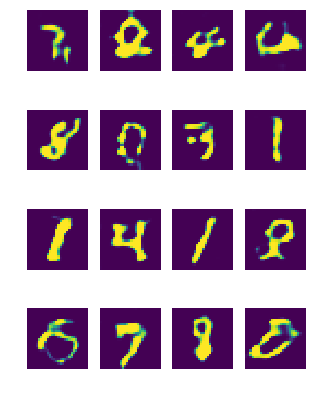

In [5]:
if __name__=='__main__':

    if task == 'TRAIN':
        if not os.path.exists(PATH):
            os.mkdir(PATH)
    
        elif os.path.exists(PATH):
            if os.path.exists(PATH+'/checkpoint'):
                ans = input('A previous checkpoint already exists, choose the action to perform \n \n 1) Overwrite the current model saved at '+PATH+'/checkpoint \n 2) Start training a new model \n 3) Restore and continue training the previous model \n ')
                
                if ans == '1':
                    print('Overwriting existing model in '+PATH)
                    for file in os.listdir(PATH):
                        file_path = os.path.join(PATH, file)
                        try:
                            if os.path.isfile(file_path):
                                os.unlink(file_path)
                            #elif os.path.isdir(file_path): shutil.rmtree(file_path)
                        except Exception as e:
                            print(e)
                            
                elif ans == '2':
                    PATH = input('Specify the name of the model, a new directory will be created.\n')
                    os.mkdir(PATH)    
        
        mnist()
   
    elif task == 'TEST': 
        if not os.path.exists(PATH+'/checkpoint'):
            print('No checkpoint to test')
        else:
            mnist()

In [ ]:
#First discriminator score:
#0.2656